🏠집 값 예측하기
=
데이터 전처리
-
필요한 라이브러리 임포트

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

데이터 받아오기

In [2]:
train = pd.read_csv("/Users/hanjaemin/Desktop/aiffel/House/train.csv")
test = pd.read_csv("/Users/hanjaemin/Desktop/aiffel/House/test.csv")

데이터 전처리를 위해서 train에 정답인 price를 뺀 후 data 에 병합한다.

In [3]:
y = train['price']
del train['price']
data = pd.concat([train, test], axis='index')

isnull 메소드를 사용해서 결측치를 검사해보자

In [4]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


결측치는 괜찮아 보이니 데이터를 살펴본다

In [5]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21503 non-null  int64  
 1   date           21503 non-null  object 
 2   bedrooms       21503 non-null  int64  
 3   bathrooms      21503 non-null  float64
 4   sqft_living    21503 non-null  int64  
 5   sqft_lot       21503 non-null  int64  
 6   floors         21503 non-null  float64
 7   waterfront     21503 non-null  int64  
 8   view           21503 non-null  int64  
 9   condition      21503 non-null  int64  
 10  grade          21503 non-null  int64  
 11  sqft_above     21503 non-null  int64  
 12  sqft_basement  21503 non-null  int64  
 13  yr_built       21503 non-null  int64  
 14  yr_renovated   21503 non-null  int64  
 15  zipcode        21503 non-null  int64  
 16  lat            21503 non-null  float64
 17  long           21503 non-null  float64
 18  sqft_li

In [7]:
type(data['date'].values[0])

str

date 열의 성분은 날짜이면서 데이터 타입이 문자열이니 년, 월만 받을 수 있게 전처리를 해줍니다.

In [8]:
data['date'] = data['date'].apply(lambda x: x[:6]).astype(int)
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


id 값은 의미가 없으니 삭제하고, 나머지 값들의 분포를 sns.kdeplot함수를 사용해서 확인한다

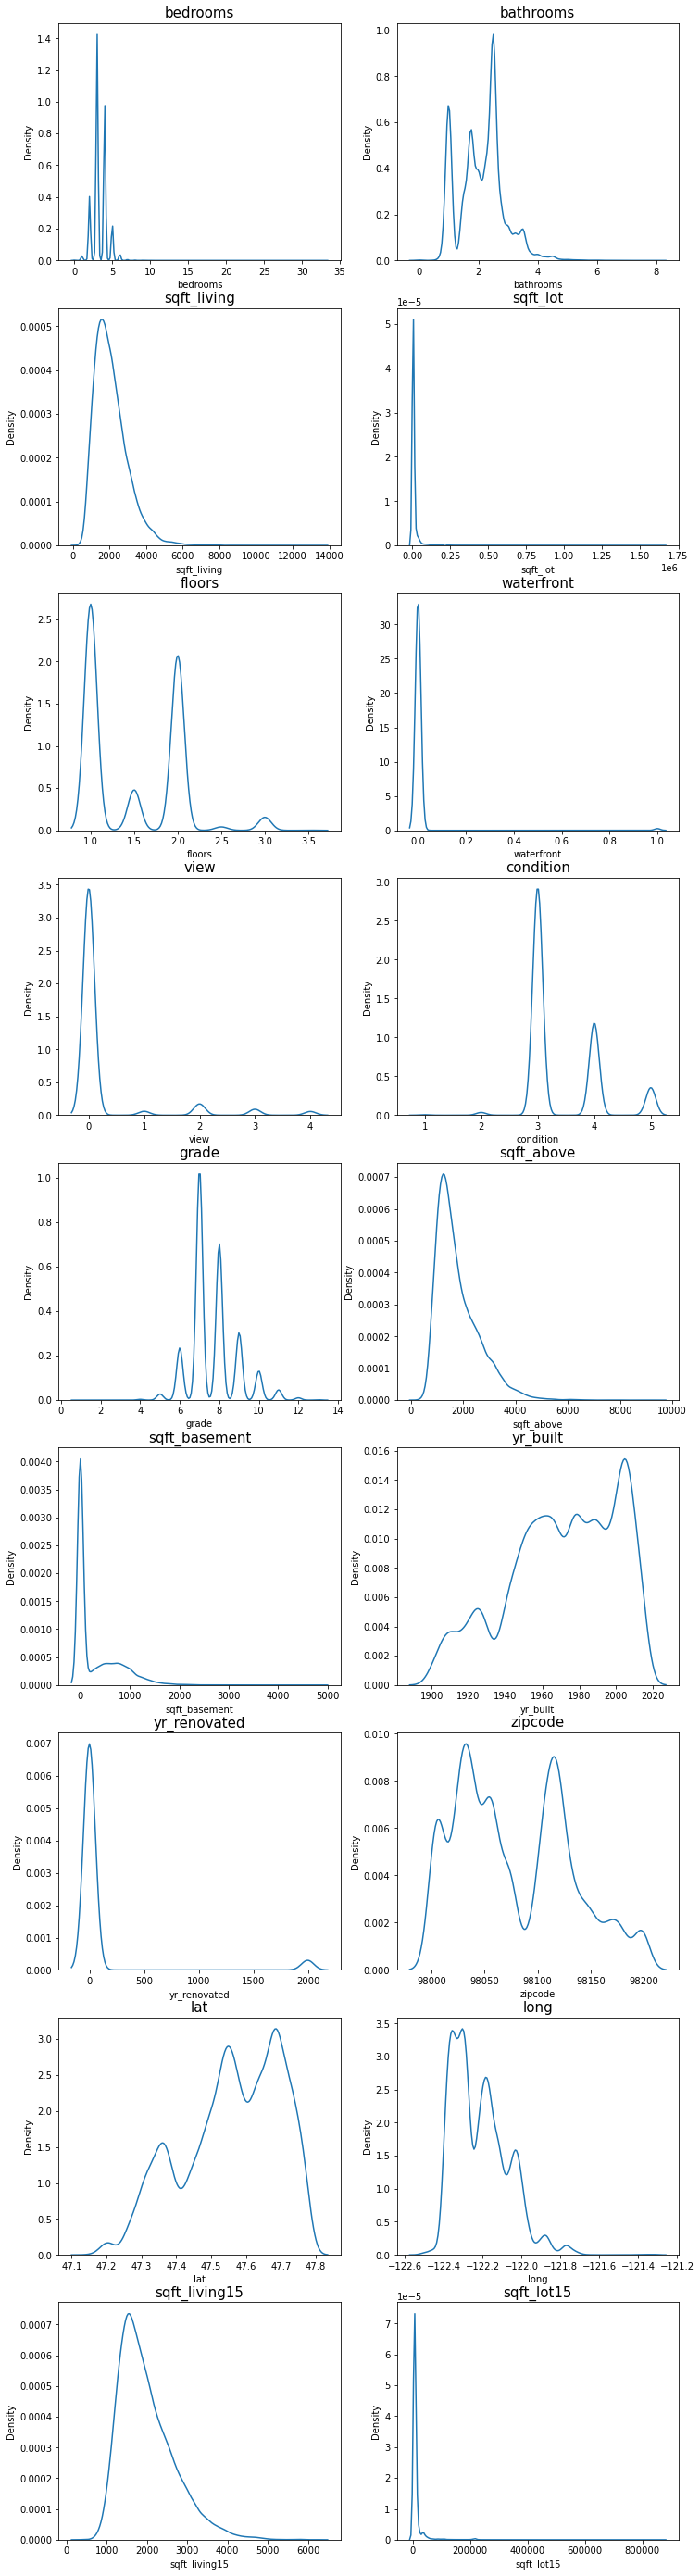

In [9]:
del data['id']

fig ,ax = plt.subplots(9, 2, figsize=(12, 50))

count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19:
            break

bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 컬럼이 한쪽으로 치우친 경향을 보이기 떄문에 np.log1p 함수를 이용한다.

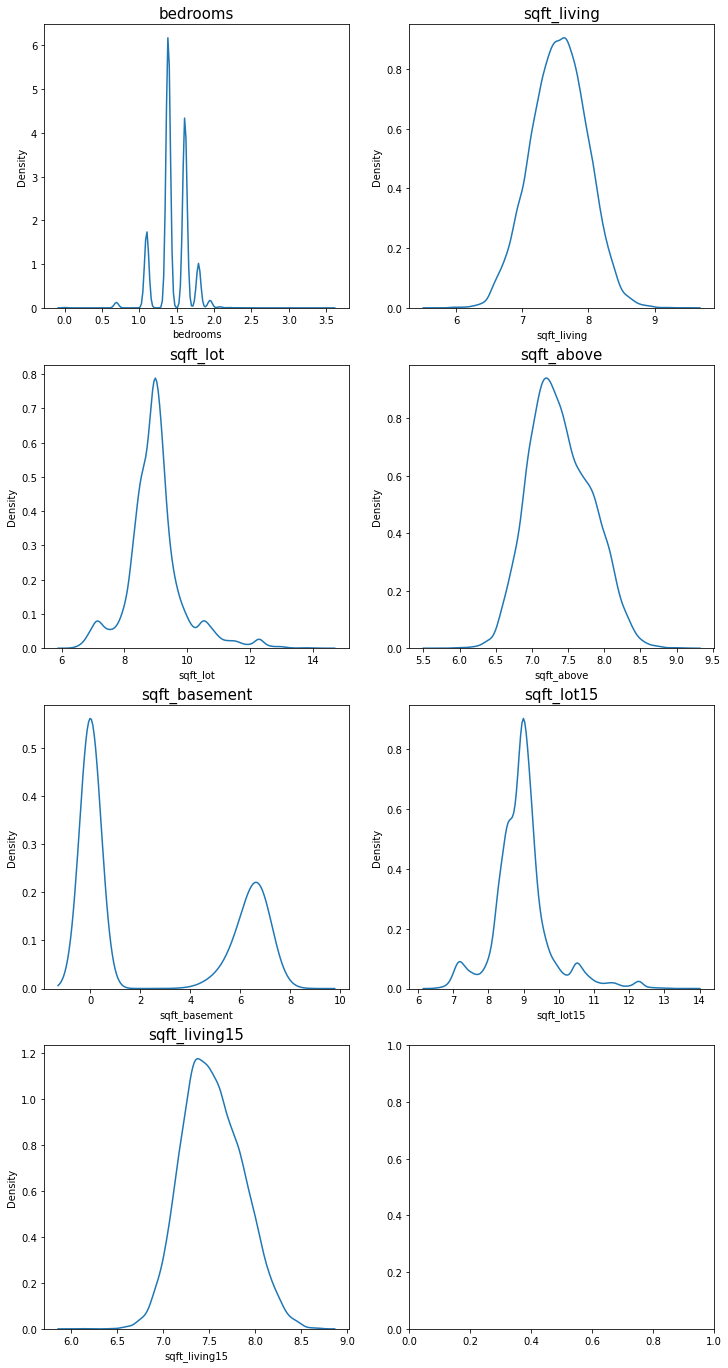

In [10]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

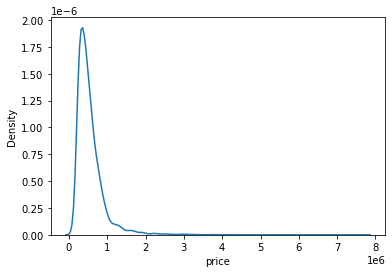

In [11]:
sns.kdeplot(y)

y = np.log1p(y)

<AxesSubplot:xlabel='price', ylabel='Density'>

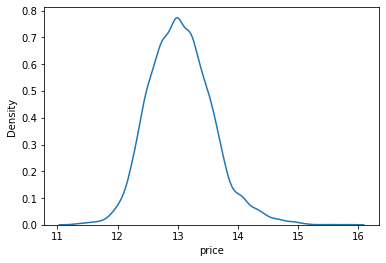

In [12]:
sns.kdeplot(y)

전처리 과정이 끝났으면 data 에서 train 과 test 를 다시 분리한다

In [13]:
test = data.iloc[len(train):, :]
train = data.iloc[:len(train), :]

print(train.shape)
print(test.shape)

(15035, 19)
(6468, 19)


학습에 사용할 모델은 LGBRegressor이고, hyper parameter는 max_depth와 n_estimators를 조정한다. 조정 방법은 sklearn.model_selection 라이브러리의 GridSearchCV 함수를 사용한다

In [14]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [15]:
model = LGBMRegressor(random_state=2020)
param_grid = {
    'n_estimators': range(400, 751, 50),
    'max_depth': range(5, 16, 1)
}
my_GridSearch(model, train, y, param_grid)

Fitting 5 folds for each of 88 candidates, totalling 440 fits
[CV] END ......................max_depth=5, n_estimators=400; total time=   0.4s
[CV] END ......................max_depth=5, n_estimators=400; total time=   0.4s
[CV] END ......................max_depth=5, n_estimators=400; total time=   0.4s
[CV] END ......................max_depth=5, n_estimators=400; total time=   0.5s
[CV] END ......................max_depth=5, n_estimators=400; total time=   0.5s
[CV] END ......................max_depth=5, n_estimators=450; total time=   0.5s
[CV] END ......................max_depth=5, n_estimators=450; total time=   0.5s
[CV] END ......................max_depth=5, n_estimators=450; total time=   0.5s
[CV] END ......................max_depth=5, n_estimators=450; total time=   0.5s
[CV] END ......................max_depth=5, n_estimators=450; total time=   0.8s
[CV] END ......................max_depth=5, n_estimators=500; total time=   0.5s
[CV] END ......................max_depth=5, n_e

,max_depth,n_estimators,score,RMSLE
40,10,400,-0.026118,0.161609
41,10,450,-0.026173,0.161782
16,7,400,-0.026183,0.161811
56,12,400,-0.026206,0.161883
42,10,500,-0.026241,0.161992
...,...,...,...,...
77,14,650,-0.026654,0.163261
78,14,700,-0.026674,0.163323
31,8,750,-0.026683,0.163348
87,15,750,-0.026713,0.163441


In [16]:
model = LGBMRegressor(random_state=2020)
param_grid = {
    'n_estimators': range(400, 501, 10),
    'max_depth': range(8, 13, 1)
}
my_GridSearch(model, train, y, param_grid)

Fitting 5 folds for each of 55 candidates, totalling 275 fits
[CV] END ......................max_depth=8, n_estimators=400; total time=   0.8s
[CV] END ......................max_depth=8, n_estimators=400; total time=   0.8s
[CV] END ......................max_depth=8, n_estimators=400; total time=   0.8s
[CV] END ......................max_depth=8, n_estimators=400; total time=   0.8s
[CV] END ......................max_depth=8, n_estimators=400; total time=   0.9s
[CV] END ......................max_depth=8, n_estimators=410; total time=   0.8s
[CV] END ......................max_depth=8, n_estimators=410; total time=   0.8s
[CV] END ......................max_depth=8, n_estimators=410; total time=   0.8s
[CV] END ......................max_depth=8, n_estimators=410; total time=   0.8s
[CV] END ......................max_depth=8, n_estimators=410; total time=   0.9s
[CV] END ......................max_depth=8, n_estimators=420; total time=   0.8s
[CV] END ......................max_depth=8, n_e

,max_depth,n_estimators,score,RMSLE
22,10,400,-0.026118,0.161609
23,10,410,-0.026128,0.161641
25,10,430,-0.026146,0.161698
24,10,420,-0.026153,0.161718
26,10,440,-0.026156,0.161728
27,10,450,-0.026173,0.161782
28,10,460,-0.026196,0.161851
44,12,400,-0.026206,0.161883
45,12,410,-0.026206,0.161884
46,12,420,-0.026212,0.161901


max_depth : 10, n_estimators : 400 기준으로 학습을 진행 후 평가해 보자

In [17]:
model = LGBMRegressor(random_state=2020, max_depth=10, n_estimators=400)

model.fit(train, y)
y_pred = model.predict(test)

result = {
    'id': range(len(train), len(train) + len(test)),
    'price': np.expm1(y_pred)
}

result = pd.DataFrame(result)
result.to_csv("~/Desktop/submission.csv", index=False)

110386 점을 얻었다.

In [18]:
model = LGBMRegressor(random_state=2020)
param_grid = {
    'n_estimators': range(400, 501, 10),
    'max_depth': range(9, 11, 1)
}
my_GridSearch(model, train, y, param_grid)

Fitting 5 folds for each of 22 candidates, totalling 110 fits
[CV] END ......................max_depth=9, n_estimators=400; total time=   0.9s
[CV] END ......................max_depth=9, n_estimators=400; total time=   0.9s
[CV] END ......................max_depth=9, n_estimators=400; total time=   0.9s
[CV] END ......................max_depth=9, n_estimators=400; total time=   1.0s
[CV] END ......................max_depth=9, n_estimators=400; total time=   0.9s
[CV] END ......................max_depth=9, n_estimators=410; total time=   0.9s
[CV] END ......................max_depth=9, n_estimators=410; total time=   0.8s
[CV] END ......................max_depth=9, n_estimators=410; total time=   0.9s
[CV] END ......................max_depth=9, n_estimators=410; total time=   0.9s
[CV] END ......................max_depth=9, n_estimators=410; total time=   0.9s
[CV] END ......................max_depth=9, n_estimators=420; total time=   0.9s
[CV] END ......................max_depth=9, n_e

,max_depth,n_estimators,score,RMSLE
11,10,400,-0.026118,0.161609
12,10,410,-0.026128,0.161641
14,10,430,-0.026146,0.161698
13,10,420,-0.026153,0.161718
15,10,440,-0.026156,0.161728
16,10,450,-0.026173,0.161782
17,10,460,-0.026196,0.161851
18,10,470,-0.026215,0.161912
19,10,480,-0.026233,0.161966
20,10,490,-0.026241,0.161990


In [19]:
model = LGBMRegressor(random_state=2020, max_depth=10, n_estimators=500)

model.fit(train, y)
y_pred = model.predict(test)

result = {
    'id': range(len(train), len(train) + len(test)),
    'price': np.expm1(y_pred)
}

result = pd.DataFrame(result)
result.to_csv("~/Desktop/submission.csv", index=False)

얘는 110185점이 나왔다.

In [20]:
len(set(train['zipcode']))

70

zipcode는 약 만 오천개의 데이터 중 70개로만 분리되어 있었다.

<AxesSubplot:>

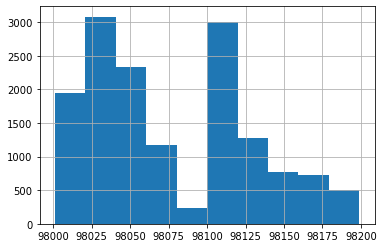

In [21]:
train['zipcode'].hist()

이를 수치형 데이터로 나타내기 보다는 원 핫 인코딩을 적용하여 범주형 데이터로 취급하는게 좋을 듯 하다
얘를 해결하기 위해 pokemon 에서 타입별로 원 핫 인코딩한 사례를 적용하자

In [22]:
data = pd.concat([train, test], axis='index')
data.shape

(21503, 19)

In [23]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118


In [24]:
zipcode_list = list(data['zipcode'].value_counts().index.sort_values())

In [25]:
len(zipcode_list)

70

총 70개의 zipcode에 대해서 순서대로 정렬한 리스트를 사용해 원 핫 인코딩을 해주자

In [26]:
for number in zipcode_list:
    data[number] = (data['zipcode'] == number)



In [27]:
data[['zipcode'] + zipcode_list]

,zipcode,98001,98002,98003,98004,98005,98006,98007,98008,98010,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,98178,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,98028,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,98074,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,98003,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,98198,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,98010,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
6464,98144,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6465,98116,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6466,98144,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


잘 할당된 모습을 볼 수 있다.

이제 필요없어진 'zipcode' 열을 없애고 다시 데이터를 분리해 주자

In [28]:
del data['zipcode']

In [29]:
test = data.iloc[len(train):, :]
train = data.iloc[:len(train), :]

print(train.shape)
print(test.shape)

(15035, 88)
(6468, 88)


다시 위에서 한 것처럼 학습을 진행해 보자

In [30]:
model = LGBMRegressor(random_state=2020)
param_grid = {
    'n_estimators': range(400, 751, 50),
    'max_depth': range(5, 16, 1)
}
my_GridSearch(model, train, y, param_grid)

Fitting 5 folds for each of 88 candidates, totalling 440 fits
[CV] END ......................max_depth=5, n_estimators=400; total time=   0.6s
[CV] END ......................max_depth=5, n_estimators=400; total time=   0.7s
[CV] END ......................max_depth=5, n_estimators=400; total time=   0.7s
[CV] END ......................max_depth=5, n_estimators=400; total time=   0.7s
[CV] END ......................max_depth=5, n_estimators=400; total time=   0.7s
[CV] END ......................max_depth=5, n_estimators=450; total time=   0.7s
[CV] END ......................max_depth=5, n_estimators=450; total time=   0.7s
[CV] END ......................max_depth=5, n_estimators=450; total time=   0.7s
[CV] END ......................max_depth=5, n_estimators=450; total time=   0.7s
[CV] END ......................max_depth=5, n_estimators=450; total time=   0.7s
[CV] END ......................max_depth=5, n_estimators=500; total time=   0.7s
[CV] END ......................max_depth=5, n_e

피쳐를 좁혀서 다시 시도해보자

In [ ]:
model = LGBMRegressor(random_state=2020)
param_grid = {
    'n_estimators': range(400, 501, 10),
    'max_depth': range(10, 16, 1)
}
my_GridSearch(model, train, y, param_grid)

Fitting 5 folds for each of 66 candidates, totalling 330 fits
[CV] END .....................max_depth=10, n_estimators=400; total time=   0.9s
[CV] END .....................max_depth=10, n_estimators=400; total time=   0.9s
[CV] END .....................max_depth=10, n_estimators=400; total time=   0.9s
[CV] END .....................max_depth=10, n_estimators=400; total time=   0.9s
[CV] END .....................max_depth=10, n_estimators=400; total time=   0.9s
[CV] END .....................max_depth=10, n_estimators=410; total time=   0.8s
[CV] END .....................max_depth=10, n_estimators=410; total time=   0.8s
[CV] END .....................max_depth=10, n_estimators=410; total time=   0.9s
[CV] END .....................max_depth=10, n_estimators=410; total time=   0.8s
[CV] END .....................max_depth=10, n_estimators=410; total time=   0.9s
[CV] END .....................max_depth=10, n_estimators=420; total time=   0.9s
[CV] END .....................max_depth=10, n_e

,max_depth,n_estimators,score,RMSLE
44,14,400,-0.025998,0.161240
24,12,420,-0.026023,0.161316
22,12,400,-0.026026,0.161326
45,14,410,-0.026031,0.161340
23,12,410,-0.026034,0.161349
...,...,...,...,...
6,10,460,-0.026267,0.162071
7,10,470,-0.026272,0.162086
8,10,480,-0.026289,0.162139
9,10,490,-0.026295,0.162157


이걸로 테스트해보자

In [ ]:
model = LGBMRegressor(random_state=2020, max_depth=14, n_estimators=400)

model.fit(train, y)
y_pred = model.predict(test)

result = {
    'id': range(len(train), len(train) + len(test)),
    'price': np.expm1(y_pred)
}

result = pd.DataFrame(result)
result.to_csv("~/Desktop/submission.csv", index=False)

In [ ]:
result.head()

,id,price
0,15035,4.865361e+05
1,15036,5.225466e+05
2,15037,1.383612e+06
3,15038,3.170672e+05
4,15039,3.285108e+05


112959.16856 오히려 늘어났다 ㅠㅠ

In [ ]:
model = LGBMRegressor(random_state=2020, max_depth=10, n_estimators=500)

model.fit(train, y)
y_pred = model.predict(test)

result = {
    'id': range(len(train), len(train) + len(test)),
    'price': np.expm1(y_pred)
}

result = pd.DataFrame(result)
result.to_csv("~/Desktop/submission.csv", index=False)

# 회고

무슨 짓을 해봐도 노드에서 처음 했을 때보다 나아지기가 힘들었다. 노드가 애초에 최적화가 잘 되어있는 방식으로 전처리를 진행하고 모델을 선정한 듯 하다.  
하지만 데이터를 내 생각에는 합리적인 방식으로 전처리를 진행해도 결과가 나아지지 않는 점은 납득하기 힘들었다. 모델 자체에 대한 이해가 없기 떄문인걸까.. 